## Context
Satellite image Classification Dataset-RSI-CB256 , This dataset has 4 different classes mixed from Sensors and google map snapshot

## Content
The past years have witnessed great progress on remote sensing (RS) image interpretation and its wide applications. With RS images becoming more accessible than ever before, there is an increasing demand for the automatic interpretation of these images. In this context, the benchmark datasets serve as essential prerequisites for developing and testing intelligent interpretation algorithms. After reviewing existing benchmark datasets in the research community of RS image interpretation, this article discusses the problem of how to efficiently prepare a suitable benchmark dataset for RS image interpretation. Specifically, we first analyze the current challenges of developing intelligent algorithms for RS image interpretation with bibliometric investigations. We then present the general guidance on creating benchmark datasets in efficient manners. Following the presented guidance, we also provide an example on building RS image dataset, i.e., Million-AID, a new large-scale benchmark dataset containing a million instances for RS image scene classification. Several challenges and perspectives in RS image annotation are finally discussed to facilitate the research in benchmark dataset construction. We do hope this paper will provide the RS community an overall perspective on constructing large-scale and practical image datasets for further research, especially data-driven ones.

## Task 1: Create a classification model in Pytorch
## Task 2: Study what is Data augmentation, explain it and apply it

### Step 1: Set Up Data Loading
In PyTorch, torchvision provides tools to handle image datasets, including data loading and basic transformations. Since you have a folder structure where each subfolder represents a class, we can use ImageFolder to load the data easily.

In [52]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pathlib import Path

# Define paths and transformation (with updated instructions)
data_dir = Path("Data_satellite")

# Define the transformations as per your professor's recommendation
transform = transforms.Compose([
    transforms.ToTensor(),                               # Convert the image to a tensor with values in [0, 1]
    transforms.ConvertImageDtype(torch.float16),         # Convert the tensor to float16 for efficiency
    transforms.CenterCrop(64)                            # Center crop to 64x64
])

# Load the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Load data using DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


### Step 2: Define the Model Architecture
For classification, you can start with a basic Convolutional Neural Network (CNN). Alternatively, you might use a pre-trained model (like ResNet) to leverage transfer learning, especially if the dataset size is limited.

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Update fc1 input size to 16384 to match the new image dimensions
        self.fc1 = nn.Linear(16 * 16 * 64, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = SimpleCNN(num_classes=4)


### Step 3: Define Loss and Optimizer
For a classification task, use CrossEntropyLoss as the loss function. An optimizer like Adam is often effective.

In [54]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Step 4: Train the Model
Set up the training loop to feed the images through the model, calculate the loss, and update the model weights.

In [55]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model = SimpleCNN(num_classes=4).half()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device).half(), labels.to(device)  # Convert images to float16, labels can remain in int64
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device).half(), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Accuracy: {100 * correct / total:.2f}%')


Epoch [1/10], Loss: 1.3823
Validation Accuracy: 23.35%
Epoch [2/10], Loss: 1.3823
Validation Accuracy: 23.35%
Epoch [3/10], Loss: 1.3820
Validation Accuracy: 23.35%
Epoch [4/10], Loss: 1.3821
Validation Accuracy: 23.35%
Epoch [5/10], Loss: 1.3823
Validation Accuracy: 23.35%
Epoch [6/10], Loss: 1.3820
Validation Accuracy: 23.35%
Epoch [7/10], Loss: 1.3824
Validation Accuracy: 23.35%
Epoch [8/10], Loss: 1.3821
Validation Accuracy: 23.35%
Epoch [9/10], Loss: 1.3823
Validation Accuracy: 23.35%
Epoch [10/10], Loss: 1.3818
Validation Accuracy: 23.35%


### Step 5: Save the Model
Once trained, save the model for future inference or evaluation.

In [56]:
torch.save(model.state_dict(), "satellite_classification_model.pth")

# Is this task 2??

In [57]:
# prompt: import drive

#from google.colab import drive
#drive.mount('/content/drive')

In [58]:
import os
#for dirname, _, filenames in os.walk('/content/drive/MyDrive/DataIntesive/Data/Data_satellite'):
#    print(dirname)

# Folder Data_satellite contains 3 subfolders: cloudy, water, green_area and desert
for dirname, _, filenames in os.walk('Data_satellite'):
    print(dirname)

Data_satellite
Data_satellite/cloudy
Data_satellite/water
Data_satellite/green_area
Data_satellite/desert


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [60]:
from tqdm import tqdm

# We reduce image size to reduce computational cost

In [61]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(64),
                                transforms.ToTensor()])

In [62]:
# dataset = ImageFolder('/content/drive/MyDrive/DataIntesive/Data/Data_satellite/', transform=transform)
dataset = ImageFolder('Data_satellite/', transform=transform)

In [63]:
dataset[1][0].shape

torch.Size([3, 64, 64])

# Check Classes

In [64]:
dataset.classes


['cloudy', 'desert', 'green_area', 'water']

In [65]:
len(dataset)


832

In [66]:
from collections import Counter
value_counts = dict(Counter(dataset.targets))

In [67]:
value_counts = dict(zip(dataset.classes, value_counts.values()))

print(value_counts)

{'cloudy': 201, 'desert': 210, 'green_area': 214, 'water': 207}


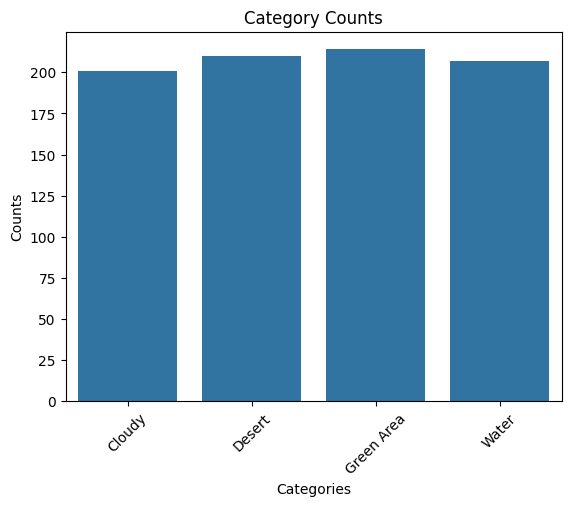

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=list(value_counts.keys()), y= list(value_counts.values()))
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Category Counts')
plt.xticks(range(4),labels = ["Cloudy", "Desert", "Green Area", "Water"], rotation = 45)
plt.show()

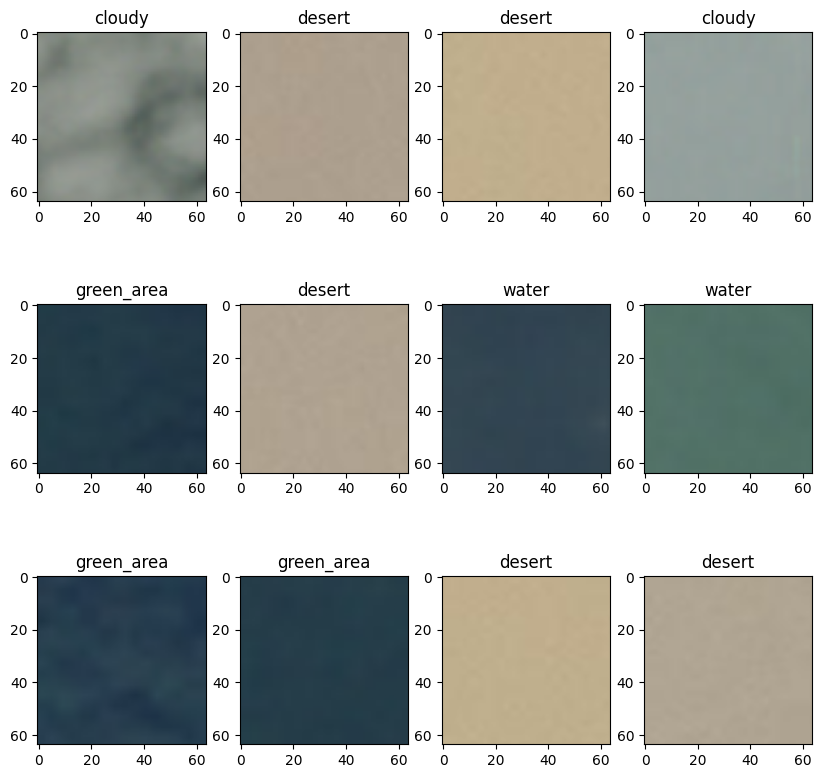

In [69]:
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 3
for i in range(1, columns * rows + 1):
    idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[idx]
    class_name = dataset.classes[label]
    fig.add_subplot(rows, columns, i)
    plt.title(class_name)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [70]:
test_size = 0.2

num_dataset = len(dataset)
num_test = int(num_dataset * test_size)
num_train = num_dataset - num_test
print('Number of Points in Dataset - {0}'.format(num_dataset))
print('Number of Points in Training Dataset - {0}'.format(num_train))
print('Number of Points in Testing Dataset - {0}'.format(num_test))

Number of Points in Dataset - 832
Number of Points in Training Dataset - 666
Number of Points in Testing Dataset - 166


In [71]:
train_set, test_set = torch.utils.data.random_split(dataset, [num_train, num_test])
train_set[0][0].shape

torch.Size([3, 64, 64])

In [72]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

In [73]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()


    def forward(self, x):

        return x

# Create an instance of the model
model = CNNModel()

# Print the model summary
print(model)

CNNModel()


In [74]:
# Move the model to the available device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel()

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

ValueError: optimizer got an empty parameter list

In [ ]:
# Training loop
train_accuracies = []
test_accuracies = []
num_epochs = 25
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track train loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate train accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = train_loss / total_train

    train_accuracies.append(train_accuracy)
    # Evaluation (Test)
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
                        # Track test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate test accuracy and loss
    test_accuracy = correct_test / total_test
    test_loss = test_loss / total_test

    test_accuracies.append(test_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")